In [1]:
# preamble, load all required packages and setup some stuff
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pylab
import seaborn as sns
from mackey_glass import Mackey_Glass
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as mticker
s_fmt = mticker.ScalarFormatter(useMathText=True)

sns.set_theme(context='paper', style='whitegrid', palette='Dark2', font_scale=.75)  # for plots
pylab.rcParams['figure.dpi'] = 150

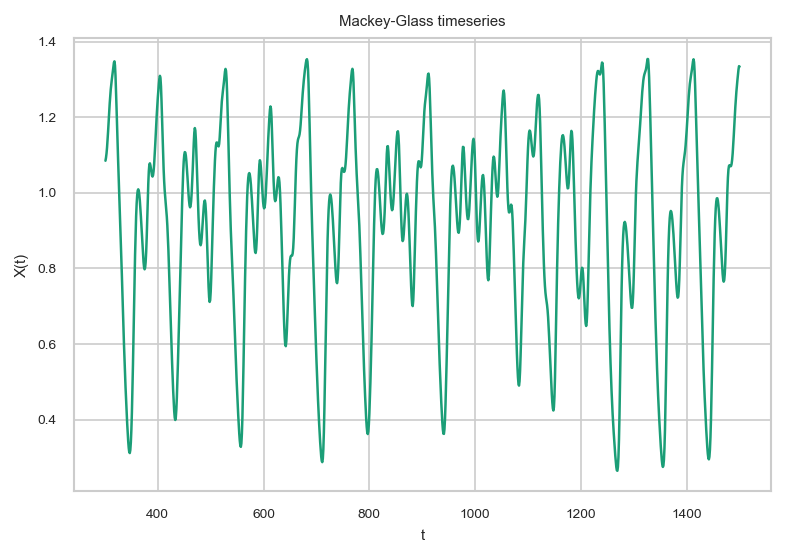

In [2]:
# plot Mackey-Glass timeseries
mg_df = pd.read_csv('data/mackey_glass.csv')

fig, ax = plt.subplots()
sns.lineplot(x='t', y='X(t+0)', data=mg_df, ax=ax)
ax.set_ylabel('X(t)')
ax.set_title('Mackey-Glass timeseries')
plt.show()

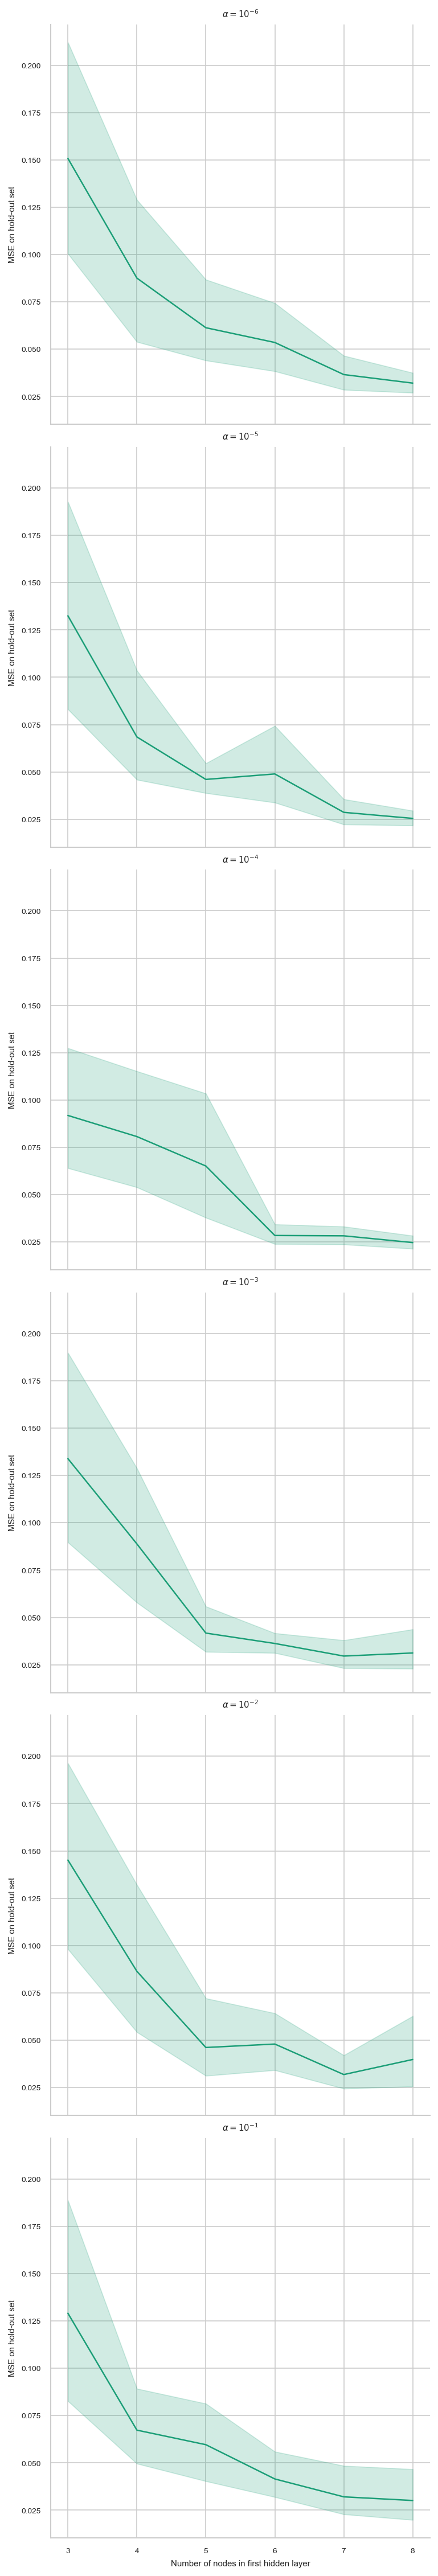

In [3]:
# load results of two-layer MLP eval and plot them
mlp_2_df = pd.read_csv('data/two_layer_perceptrons_scores.csv')
mlp_2_df['alpha'] = mlp_2_df['alpha'].astype('category')
mlp_2_df['alpha_str'] = mlp_2_df['alpha'].apply(s_fmt.format_data).astype('category')

fg = sns.relplot(kind='line', x='layer0_nodes', y='mse', row='alpha_str', data=mlp_2_df)
fg.set_xlabels('Number of nodes in first hidden layer')
fg.set_ylabels('MSE on hold-out set')
fg.set_titles('$\\alpha =  {row_name}$')

# fig, ax = plt.subplots()
# sns.lineplot(x='layer0_nodes', y='mse', hue='alpha', data=mlp_2_df, ax=ax)
# ax.set_xlabel('Number of nodes in hidden layer')
# ax.set_ylabel('MSE on hold-out set')
# ax.set_title('Two-layer perceptron evaluation')
# ax.legend(title='Regularization strength ($\\alpha$)', ncol=3)
plt.show()

Best 2-layer perceptron: 8 nodes in hidden layer, alpha = 0.0001


c:\users\manue\workspace\annda_ht20_lab1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


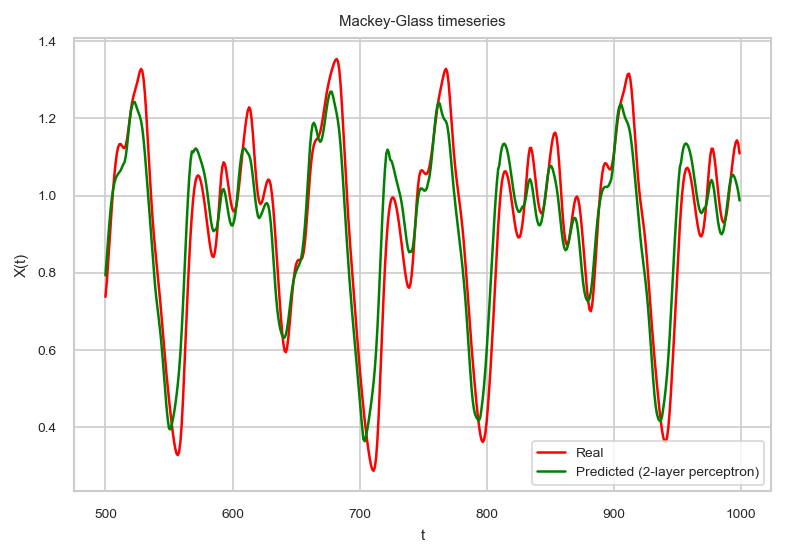

In [4]:
# find the best 2-layer perceptron by minimizing the MSE
mse_means = mlp_2_df.groupby(['alpha', 'layer0_nodes']).mean()
alpha, layer0_nodes = mse_means['mse'].idxmin()

print(f'Best 2-layer perceptron: {layer0_nodes} nodes in hidden layer, alpha = {alpha}')

# build the best perceptron, train it and test it

# turn Mackey-Glass DataFrame into numpy arrays
# scikit-learn uses input matrices with rows=samples, columns=features
# last column is the input t, we don't want that
X = mg_df.to_numpy()[:, :-2]
Y = mg_df.to_numpy()[:, -2]

# build test data
mg = Mackey_Glass()
test_t = list(range(500, 1000))  # cleary unseen samples
Y_real = [mg.fn(t) for t in test_t]
X_test = np.array([[mg.fn(t + d) for d in [-20, -15, -10, -5, 0]] for t in test_t])

best_2layers = MLPRegressor(early_stopping=True, hidden_layer_sizes=(layer0_nodes,), alpha=alpha)
best_2layers.fit(X, Y)

# now use the fitted estimator to predict
Y_pred = best_2layers.predict(X_test)

# plot predictions vs real values
fig, ax = plt.subplots()
ax.plot(test_t, Y_real, 'r-', label='Real')
ax.plot(test_t, Y_pred, 'g-', label='Predicted (2-layer perceptron)')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.set_title('Mackey-Glass timeseries')
ax.legend()
plt.show()

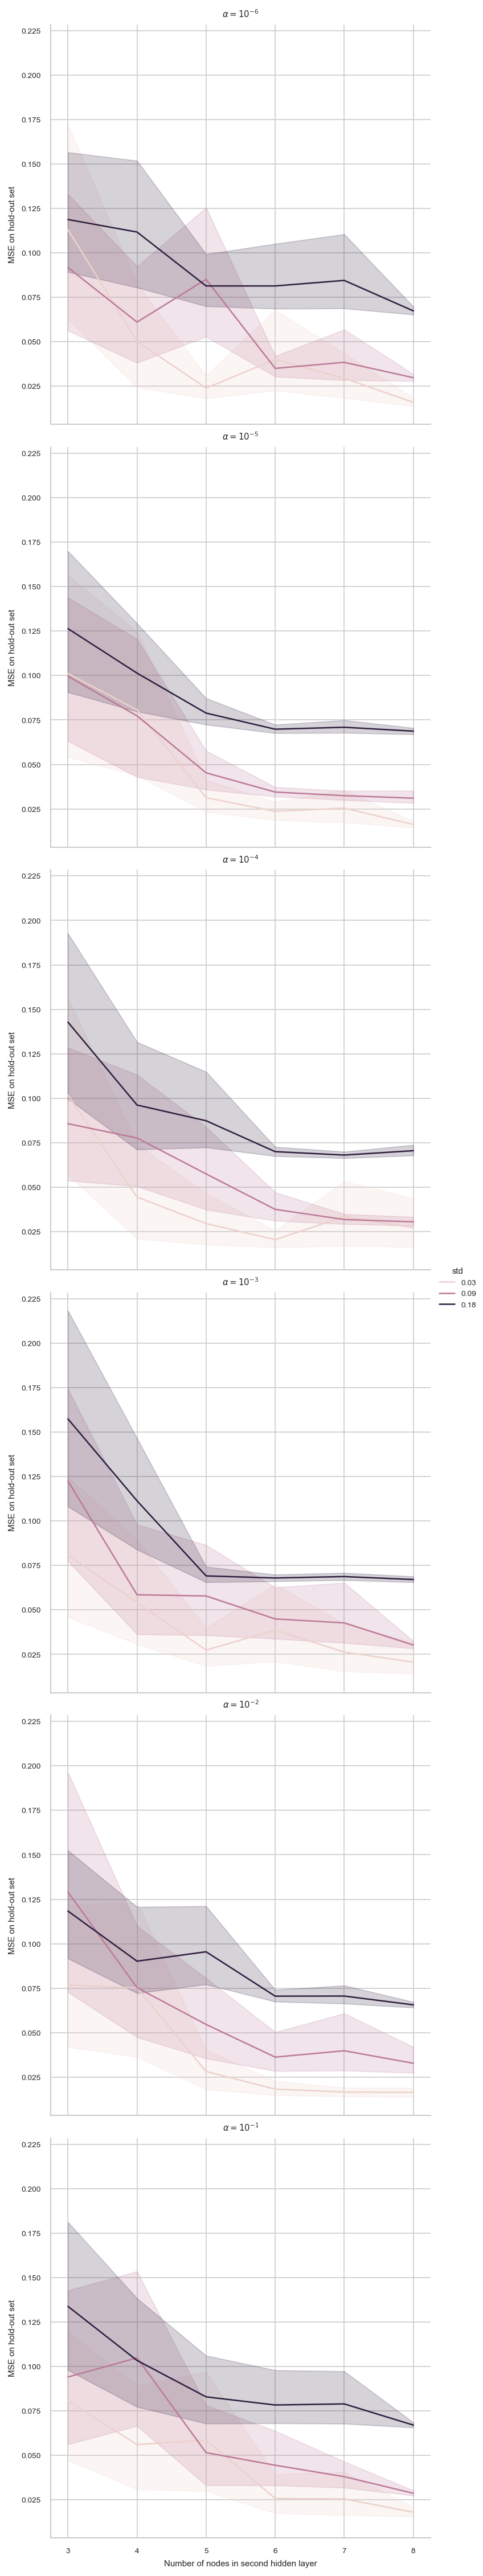

In [5]:
# load results of three-layer MLP eval and plot them
mlp_3_df = pd.read_csv('data/three_layer_perceptrons_scores.csv')
mlp_3_df['alpha'] = mlp_3_df['alpha'].astype('category')
mlp_3_df['alpha_str'] = mlp_3_df['alpha'].apply(s_fmt.format_data).astype('category')

# fig, ax = plt.subplots()
fg = sns.relplot(kind='line', x='layer1_nodes', y='mse', hue='std', row='alpha_str', data=mlp_3_df)
fg.set_xlabels('Number of nodes in second hidden layer')
fg.set_ylabels('MSE on hold-out set')
fg.set_titles('$\\alpha = {row_name}$')
# fg.set_title('Three-layer perceptron evaluation')
# fg.legend(title='Regularization strength ($\\alpha$)', ncol=3)

plt.show()

Best 3-layer perceptron: 8 in first hidden layer, 8 nodes in second hidden layer, alpha = 1e-06


c:\users\manue\workspace\annda_ht20_lab1\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


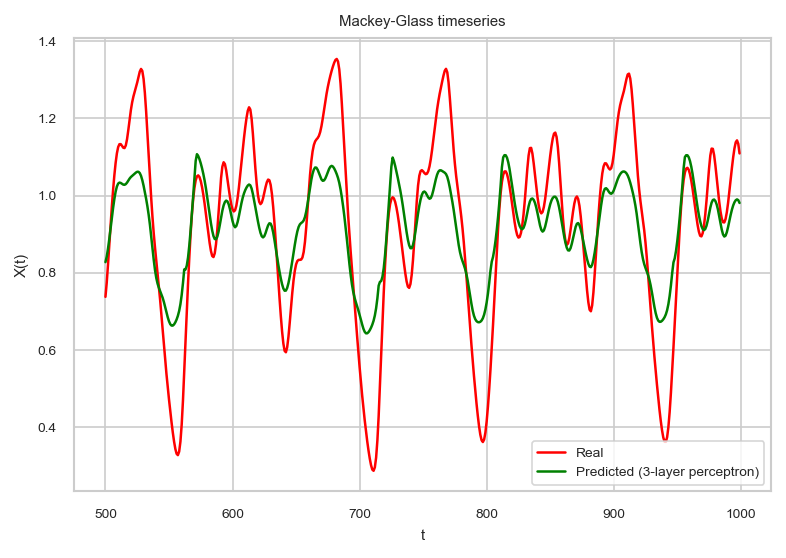

In [6]:
# again, find the best one by minimizing the average MSE
mse_means = mlp_3_df.groupby(['alpha', 'layer1_nodes']).mean()
alpha, layer1_nodes = mse_means['mse'].idxmin()

print(f'Best 3-layer perceptron: {layer0_nodes} in first hidden layer, {layer1_nodes} nodes in second hidden layer, alpha = {alpha}')

# build the best perceptron, train it and test it
best_3layers = MLPRegressor(early_stopping=True, hidden_layer_sizes=(layer0_nodes, layer1_nodes), alpha=alpha)
best_3layers.fit(X, Y)

# now use the fitted estimator to predict
Y_pred = best_3layers.predict(X_test)

# plot predictions vs real values
fig, ax = plt.subplots()
ax.plot(test_t, Y_real, 'r-', label='Real')
ax.plot(test_t, Y_pred, 'g-', label='Predicted (3-layer perceptron)')
ax.set_xlabel('t')
ax.set_ylabel('X(t)')
ax.set_title('Mackey-Glass timeseries')
ax.legend()
plt.show()

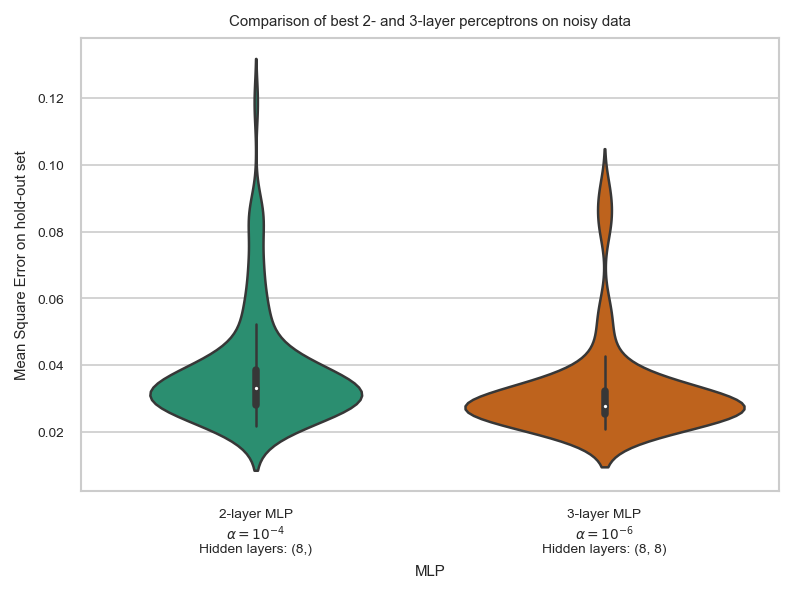

In [7]:
# compare the best 2-layer MLP and 3-layer MLP on noisy data (std = 0.09)
# load the data

mlp_2v3_df = pd.read_csv('data/2v3_noisy.0.09.csv')
mlp_2v3_df['n_layers'] = mlp_2v3_df['n_layers'].astype('category')

params_2l = best_2layers.get_params()
params_3l = best_3layers.get_params()

fig, ax = plt.subplots()
sns.violinplot(data=mlp_2v3_df, x='n_layers', y='mse', ax=ax)
ax.set_xlabel('MLP')
ax.set_xticklabels([f'2-layer MLP\n$\\alpha={s_fmt.format_data(params_2l["alpha"])}$\nHidden layers: {params_2l["hidden_layer_sizes"]}', 
                    f'3-layer MLP\n$\\alpha={s_fmt.format_data(params_3l["alpha"])}$\nHidden layers: {params_3l["hidden_layer_sizes"]}'])
ax.set_ylabel('Mean Square Error on hold-out set')
ax.set_title('Comparison of best 2- and 3-layer perceptrons on noisy data')
plt.show()

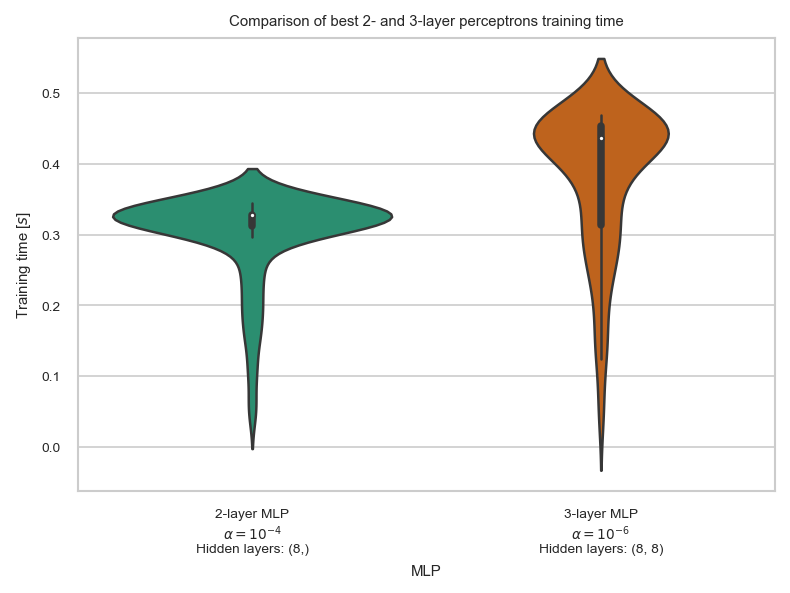

In [8]:
# some time plots
fig, ax = plt.subplots()
sns.violinplot(x='n_layers', y='training_time', data=mlp_2v3_df, ax=ax)
ax.set_xlabel('MLP')
ax.set_xticklabels([f'2-layer MLP\n$\\alpha={s_fmt.format_data(params_2l["alpha"])}$\nHidden layers: {params_2l["hidden_layer_sizes"]}', 
                    f'3-layer MLP\n$\\alpha={s_fmt.format_data(params_3l["alpha"])}$\nHidden layers: {params_3l["hidden_layer_sizes"]}'])
ax.set_ylabel('Training time [$s$]')
ax.set_title('Comparison of best 2- and 3-layer perceptrons training time')
plt.show()

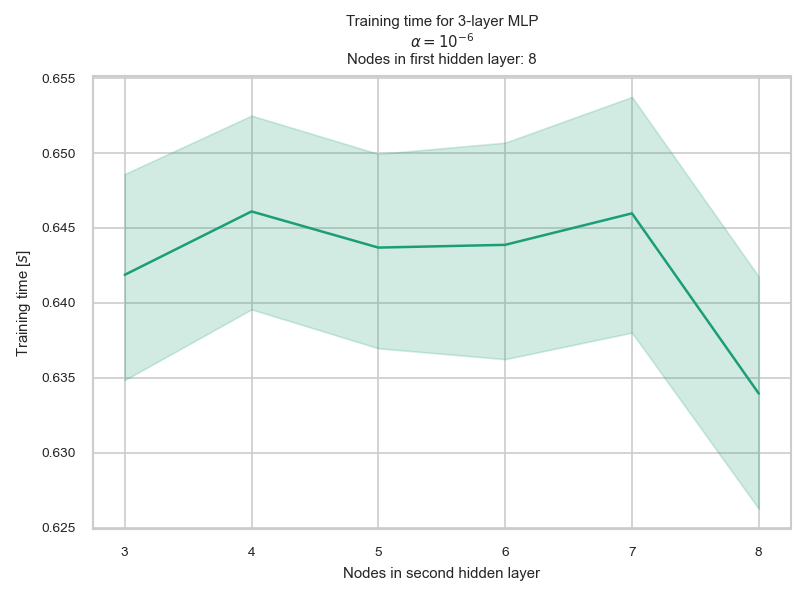

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x='layer1_nodes', y='training_time', data=mlp_3_df, ax=ax)
ax.set_xlabel('Nodes in second hidden layer')
ax.set_ylabel('Training time [$s$]')
ax.set_title(f'Training time for 3-layer MLP\n$\\alpha={s_fmt.format_data(params_3l["alpha"])}$\nNodes in first hidden layer: {params_3l["hidden_layer_sizes"][0]}')
plt.show()